# Set up

In [27]:
using PyCall
dj = pyimport("datajoint")

# RUN THE FOLLOWING ONLY ONCE:  Next time tou start up tou won't need it, the info will be saved in the local file
#
# dj.config.__setitem__("database.host", "datajoint00.pni.princeton.edu")
# dj.config.__setitem__("database.user", "YOUR PU ID")
# dj.config.__setitem__("database.password", "YOUR PU PASSWORD")
# dj.config.save_local()

dj.conn(reset=true)

schema = dj.schema("brody_tutorial2", py"locals()")


py"""
@$schema
class Mouse($dj.Manual):
      definition = '''
      mouse_id: int                  # unique mouse id
      ---
      dob: date                      # mouse date of birth
      sex: enum('M', 'F', 'U')       # sex of mouse - Male, Female, or Unknown/Unclassified
      '''
"""

mouse = py"Mouse()"


mouse.insert([
        Dict("mouse_id"=>1, "dob"=>"2020-01-01", "sex"=>"M"), 
        Dict("mouse_id"=>2, "dob"=>"2020-01-02", "sex"=>"F"),
        Dict("mouse_id"=>3, "dob"=>"2020-01-03", "sex"=>"U"),
        Dict("mouse_id"=>5, "dob"=>"2020-01-05", "sex"=>"M"), 
        Dict("mouse_id"=>6, "dob"=>"2020-01-05", "sex"=>"F"),
        Dict("mouse_id"=>7, "dob"=>"2020-01-05", "sex"=>"F")
        ], skip_duplicates=true)


py"""
schema = $dj.schema('brody_tutorial2', locals())

@schema
class Session($dj.Manual):
    definition = '''
    # Experiment session
    -> Mouse
    session_date               : date                         # date
    ---
    experiment_setup           : int                          # experiment setup ID
    experimenter               : varchar(100)                 # experimenter name
    '''

"""

session = py"Session"()

data = Dict(
  "mouse_id" => 1,
  "session_date" => "2017-05-15",
  "experiment_setup" => 0,
  "experimenter" => "Edgar Y. Walker"
)

session.insert1(data, skip_duplicates=true)


data = [
    Dict(
  "mouse_id" => 1,
  "session_date" => "2020-05-15",
  "experiment_setup" => 0,
  "experimenter" => "Boaty McBoatFace"
    ), 
    Dict(
  "mouse_id" => 3,
  "session_date" => "2020-05-15",
  "experiment_setup" => 0,
  "experimenter" => "Boaty McBoatFace"
    )
    ]

session.insert(data, skip_duplicates=true)

session

mouse_id unique mouse id,session_date date,experiment_setup experiment setup ID,experimenter experimenter name
1,2017-05-15,0,Edgar Y. Walker
1,2020-05-15,0,Boaty McBoatFace
3,2020-05-15,0,Boaty McBoatFace


In [60]:
function Neuron_make(key)
    println("Howdy, ", key)
end

py"""
Neuron_make = $Neuron_make
schema = $dj.schema('brody_tutorial2', locals())

@schema
class Neuron($dj.Imported):
    definition = '''
    -> Session
    ---
    activity: longblob    # electric activity of the neuron
    '''

    def make(self, key):
         Neuron_make(key)
"""

neuron = py"Neuron"()
neuron.populate()

Howdy, Dict{Any,Any}("session_date"=>2017-05-15,"mouse_id"=>1)
Howdy, Dict{Any,Any}("session_date"=>2020-05-15,"mouse_id"=>1)
Howdy, Dict{Any,Any}("session_date"=>2020-05-15,"mouse_id"=>3)


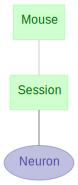

In [30]:
py"$dj.ERD($schema)"

In [31]:
neuron.populate()


Howdy, Dict{Any,Any}("session_date"=>2017-05-15,"mouse_id"=>1)
Howdy, Dict{Any,Any}("session_date"=>2020-05-15,"mouse_id"=>1)
Howdy, Dict{Any,Any}("session_date"=>2020-05-15,"mouse_id"=>3)


# Working with automated computations: Imported and Computed tables

Welcome back! In this session, we are going to continue working with the pipeline for the mouse electrophysiology example. 

In this session, we will learn to:

* import neuron activity data from data files into an `Imported` table
* compute various statistics for each neuron by defining a `Computed` table
* define a `Lookup` table to store parameters for computation
* define another `Computed` table to perform spike detection and store the detected spikes
* automatically trigger computations for all missing entries with `populate`

First things first, run the **SETUP** cell above, which will connect us to the database, define our `schema` and set up our `Mouse` and `Session` tables.

In [35]:
mouse

mouse_id unique mouse id,dob mouse date of birth,"sex sex of mouse - Male, Female, or Unknown/Unclassified"
1,2020-01-01,M
2,2020-01-02,F
3,2020-01-03,U
5,2020-01-05,M
6,2020-01-05,F
7,2020-01-05,F


In [34]:
session

mouse_id unique mouse id,session_date date,experiment_setup experiment setup ID,experimenter experimenter name
1,2017-05-15,0,Edgar Y. Walker
1,2020-05-15,0,Boaty McBoatFace
3,2020-05-15,0,Boaty McBoatFace


# Importing data from data files

Recall from the project description
> * In each experimental session, you record electrical activity from a single neuron. You use recording equipment that produces separate data files for each neuron you recorded.

Our recording equipment produces a data file for each neuron recorded. Since we record from one neuron per session, there should be one data file for each session.

In the `data` directory, you will find `.npy` (saved NumPy array) files with names like `data_100_2017-05-25.npy`.

As you might have guessed, these are the data for the recording sessions in the `Session` table, and each file are named according to the `mouse_id` and `session_date` - the attributes of the primary keys - in the format `data_{mouse_id}_{session_date}.npy`.

So `data_100_2017-05-25.npy` is the data for session identified by `mouse_id = 100` and `session_date = "2017-05-25"`.

## Looking at the data 

Let's take a quick peak at the data file content.

First, let's pick a session to load the data for. To do this we are going to first fetch the **primary key attributes** of `Session` as a list of dictionaries. We make use of the special `fetch('KEY')` syntax to achieve this.

In [36]:
keys = session.fetch("KEY")
keys

3-element Array{Dict{Any,Any},1}:
 Dict("session_date"=>2017-05-15,"mouse_id"=>1)
 Dict("session_date"=>2020-05-15,"mouse_id"=>1)
 Dict("session_date"=>2020-05-15,"mouse_id"=>3)

Any item in this list of keys can be used to uniquely identify a single session!

In [37]:
session & keys[2]

mouse_id unique mouse id,session_date date,experiment_setup experiment setup ID,experimenter experimenter name
1,2020-05-15,0,Boaty McBoatFace


Let's take the first key, and generate the file name that corresponds to this session. Remember the `data_{mouse_id}_{session_date}.npy` filename convetion!

In [38]:
key = keys[1]
key

Dict{Any,Any} with 2 entries:
  "session_date" => 2017-05-15
  "mouse_id"     => 1

In [41]:
key["mouse_id"]

1

In [46]:
filename = "data/data_$(key["mouse_id"])_$(key["session_date"]).npy"
filename

"data/data_1_2017-05-15.npy"

Here we have made use of Python's dictionary unpacking and `format` method on strings to generate the filename from the `key`.

Finally, let's load the file.

In [ ]:
data = np.load(filename)

Look at its content...

In [ ]:
data

...and check the shape of the data.

In [ ]:
data.shape

So this particular file contains a NumPy array of length 1000. This represents a (simulated) recording of raw electric activity from a single neuron over 1000 time bins.

## Defining the table for recorded neurons

We now would like to have all these recorded `Neuron` represented and stored in our data pipeline.

Since we only record a single neuron from each session, a `Neuron` can be uniquely identified by knowing the `Session` it was recorded in. For each `Neuron`, we want to store the neural activity found in the data file.

In [47]:
py"""
schema = $dj.schema('brody_tutorial2', locals())

@schema
class Neuron($dj.Imported):
    definition = '''
    -> Session
    ---
    activity: longblob    # electric activity of the neuron
    '''
"""

neuron = py"Neuron"()

mouse_id unique mouse id,session_date date,activity electric activity of the neuron


In [51]:
activity = randn(1,10)

1×10 Array{Float64,2}:
 0.975209  0.648331  -0.0762435  …  -0.910477  0.0143664  -0.750821

mouse_id unique mouse id,session_date date,activity electric activity of the neuron


Let's check the state of our pipeline.

We defined `activity` as a `longblob` so that it can store a NumPy array holding the electric activity over time. This NumPy array will be imported from the file corresponding to each neuron.

Note that our `Neuron` class inherits from `dj.Imported` instaed of `dj.Manual` like others. This is because **this table's content will depend on data imported from an external file**. The `Manual` vs `Imported` are said to specify the **tier of the table**.

## DataJoint table tiers

In DataJoint, the tier of the table indicates **the nature of the data and the data source for the table**. So far we have encountered two table tiers: `Manual` and `Imported`, and we will encounter the two other major tiers in this session. 

DataJoint tables in `Manual` tier, or simply **Manual tables** indicate that its contents are **manually** entered by either experimenters or a recording system, and its content **do not depend on external data files or other tables**. This is the most basic table type you will encounter, especially as the tables at the beggining of the pipeline. In the ERD, `Manual` tables are depicted by green rectangles.

On the other hand, **Imported tables** are understood to pull data (or *import* data) from external data files, and come equipped with functionalities to perform this importing process automatically, as we will see shortly! In the ERD, `Imported` tables are depicted by blue ellipses.

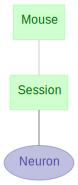

In [50]:
py"$dj.ERD($schema)"

## Importing data into the `Imported` table

Rather than filling out the content of the table manually using `insert1` or `insert` methods, we are going to make use of the `make` and `populate` logic that comes with `Imported` tables to automatically figure out what needs to be imported and perform the import!

## `make` and `populate` methods

`Imported` table comes with a special method called `populate`. Let's try calling it.

In [ ]:
neuron.populate()

Notice that `populate` call complained that a method called `make` is not implemented. Let me show a simple `make` method that will help elucidate what this is all about.

In [61]:
function Neuron_make(key)
    println("key is, ", key)
end

py"""
Neuron_make = $Neuron_make
schema = $dj.schema('brody_tutorial2', locals())

@schema
class Neuron($dj.Imported):
    definition = '''
    -> Session
    ---
    activity: longblob    # electric activity of the neuron
    '''

    def make(self, key):
         Neuron_make(key)
"""

neuron = py"Neuron"()

mouse_id unique mouse id,session_date date,activity electric activity of the neuron


Now, let's call `populate` again!

In [62]:
neuron.populate()

key is, Dict{Any,Any}("session_date"=>2017-05-15,"mouse_id"=>1)
key is, Dict{Any,Any}("session_date"=>2020-05-15,"mouse_id"=>1)
key is, Dict{Any,Any}("session_date"=>2020-05-15,"mouse_id"=>3)


When you call `populate` on an `Imported` table, this triggers DataJoint to look up all tables that the `Imported` table depends on.

For **every unique combination of entries in the depended or "parent" tables**, DataJoint calls `make` function, passing in the primary key of the parent(s).

Because `Neuron` depends on `Session`, `Neuron`'s `make` method was called for each entry of `Session`

In [63]:
py"Session"()

mouse_id unique mouse id,session_date date,experiment_setup experiment setup ID,experimenter experimenter name
1,2017-05-15,0,Edgar Y. Walker
1,2020-05-15,0,Boaty McBoatFace
3,2020-05-15,0,Boaty McBoatFace


Note that `make` only receives the *primary key attributes* of `Session` (`mouse_id` and `session_date`) but not the other attributes.

## Implementing `make`

Now we have a better understanding of `make`, let's implement `make` to perform the importing of data from file.

In [69]:
function Neuron_make(self, key)
    key["activity"] = randn(1,10)
    println("Key is ", key)
    self.insert1(key)
end

py"""
Neuron_make = $Neuron_make
schema = $dj.schema('brody_tutorial2', locals())

@schema
class Neuron($dj.Imported):
    definition = '''
    -> Session
    ---
    activity: longblob    # electric activity of the neuron
    '''

    def make(self, key):
         Neuron_make(self, key)
"""

neuron = py"Neuron"()


mouse_id unique mouse id,session_date date,activity electric activity of the neuron


In [70]:
neuron.populate()

Key is Dict{Any,Any}("session_date"=>2017-05-15,"activity"=>[-1.67488 0.0758973 2.43327 -0.607057 1.44085 -0.705126 0.0881986 0.485397 1.89029 0.355478],"mouse_id"=>1)
Key is Dict{Any,Any}("session_date"=>2020-05-15,"activity"=>[-0.991884 -0.552257 -0.434564 -0.351505 0.401872 -0.925967 0.727374 -0.506275 -1.05026 -0.605553],"mouse_id"=>1)
Key is Dict{Any,Any}("session_date"=>2020-05-15,"activity"=>[-2.81813 0.392606 1.19388 0.108052 -0.977852 -1.19959 -1.86381 -0.157183 0.684379 -1.46964],"mouse_id"=>3)


In [164]:
x = d2j((neuron & "mouse_id = 1").fetch("activity"))


2-element Array{Any,1}:
 [-1.67488 0.0758973 … 1.89029 0.355478]   
 [-0.991884 -0.552257 … -1.05026 -0.605553]

In [163]:
neuron

mouse_id unique mouse id,session_date date,activity electric activity of the neuron
1,2017-05-15,=BLOB=
1,2020-05-15,=BLOB=
3,2020-05-15,=BLOB=


In [158]:
import Dates

# List of data types that are not automatically converted, defining how to convert
# First column is Python name for the data type class, second column is corresponding Julia type
conversion_list = [
      "str"      String;
      "date"     Dates.Date;
      "ndarray"  d2j;
]

"""
function d2j(x)

Takes x, the output of a datajoint fetch() call, and converts it from PyObject formal to Julia format

= PARAMETERS:

- x      Must be a PyObject that is the output of a datajoint fetch() call

= RETURNS:

- out    The same data that was in x, but now in Julia format. In general this will
         be an Array of type Any, but if x was a single column of unique type, or a list
         of single columns, each of unique type, then those may come back as the corresponding
         type (e.g., Array of Int or Array of String).

= EXAMPLE CALL:

```jldoctest
d2j(mouse.fetch())

7×3 Array{Any,2}:
 1  2019-12-19  "M"
 2  2019-12-20  "U"
 3  2019-12-21  "M"
 4  2020-01-03  "F"
 5  2020-01-05  "M"
 6  2020-01-05  "F"
 7  2020-01-05  "F"

d2j(mouse.fetch("mouse_id"))

7-element Array{Int64,1}:
 1
 2
 3
 4
 5
 6
 7


```
"""
function d2j(x)
      out = x
      if typeof(x) <: PyObject && x.__class__.__name__ == "ndarray" &&  !isempty(x)
            # We are getting each row of the table as a row of x.
            # This means different columns will have different data types
            nrows = length(x)
            ncols = length(get(x, 0))
            out = Array{Any}(undef, nrows, ncols)
            my_type_list = Array{Type}(undef, 1, 0)
            for i=1:nrows
                  for j=1:ncols
                        # These get statements do autoconvert to Julia data types
                        out[i,j] = get(get(x, i-1), j-1)
                        # Except for integers it seems, which stay as PyObjects but can be
                        # converted as follows:
                        if typeof(out[i,j]) <: PyObject && py"hasattr($(out[i,j]), 'flatten')"
                              out[i,j] = out[i,j].flatten()[1]
                        end
                        if findfirst(typeof(out[i,j]) .== my_type_list)==nothing
                            my_type_list = hcat(my_type_list, typeof(out[i,j]))
                        end
                  end
            end
            if length(my_type_list)==1
                out = convert(Array{my_type_list[1]}, out)
            end
            return out
      elseif typeof(x) <: Array{PyObject,1}
            # We have a single column requested: ony a single data type
            if !isempty(x)
                  classname = x[1].__class__.__name__
                  # Do we know how to convert this data type?
                  u = findall(conversion_list[:,1] .== classname)
                  if !isempty(u)
                        # We do know!
                        u = u[1]
                        mytype = conversion_list[u,2]
                        if mytype == d2j
                            out = Array{Any}(undef, length(x))
                            for i=1:length(x)
                                out[i] = d2j(x[i])
                            end
                        else
                            out = Array{mytype}(undef, length(x))
                            for i=1:length(x)
                                  out[i] = convert(mytype, x[i])
                            end
                        end
                  end
            end
      elseif typeof(x) <: Array && eltype(x) <: Array
            # We have multiple columns requested as multiple outputs
            # We'll convert each one separately
            out = Array{Any}(undef, length(x))
            for i=1:length(x)
                  out[i] = d2j(x[i])
            end
      end
      return out
end


d2j

Notice that we added the missing attribute information `activity` into the `key` dictionary, and finally **inserted the entry** into `self` = `Neuron` table. The `make` method's job is to create and insert a new entry corresponding to the `key` into this table!

Finally, let's go ahead and call `populate` to actually populate the `Neuron` table, filling it with data loaded from data files!

In [ ]:
Neuron.populate()

In [ ]:
Neuron()

What happens if we call `Neuron.populate` again?

In [ ]:
Neuron.populate()

That's right - nothing! This makes sense, because we have imported `Neuron` for all entries in `Session` and nothing is left to be imported.

Now what happens if we insert a new entry into `Session`?

In [ ]:
Session.insert1({
    "mouse_id": 100,
    "session_date": "2017-06-01",
    "experiment_setup": 1,
    "experimenter": "Jacob Reimer"
    ""
})

We can find all `Session` without corresponding `Neuron` entry with the **antijoin operator** `-`

In [ ]:
# select all Session entries *without* a corresponding entry in Neuron
Session - Neuron

In [ ]:
Neuron.populate()

In [ ]:
Neuron()

# Computations in data pipeline

Now we have successfully imported all data we have into our pipeline, it's time for us to start analyzing them! 

When you perform computations in the DataJoint data pipeline, you focus and design tables in terms of **what** is it that you are computing rather than the **how**. You should think in terms of the "things" that you are computing!

Now, let's say that we want to compute the satististics, such as mean, standard deviation, and maximum value of each of our neuron's activity traces. Hence we want to compute the neuron's **activity statistics** for each neuron!

So the new "thing" or entity here is `ActivityStatistics`, where each entry corresponds to the statistics of a single `Neuron`. Let's start designing the table, paying special attention to the dependencies.

### Statistics of neuron activities

Before we create the table to store the statistics, let's think about how we might go about computing interesting statistics for a single neuron.

Let's start by fetching one neuron to work with.

In [ ]:
keys = Neuron().fetch('KEY')

# pick one key
key = keys[0]

In [ ]:
Neuron() & key

Lets go ahead and grab the `activity` data stored as numpy array. As we learned in the last session, we can `fetch` it!

In [ ]:
activity = (Neuron() & key).fetch('activity')

In [ ]:
activity

It's a bit subtle, but `fetch` returns a NumPy array of the attribute, even if the attribute contains a NumPy array. So here, we actually got a NumPy array of NumPy array. We can of course just index into it,

In [ ]:
activity[0]

but if we knew that there was only one item, we can use `fetch1` instead to save some trouble

In [ ]:
activity = (Neuron() & key).fetch1('activity')

In [ ]:
activity

Now we can compute some statistics:

In [ ]:
# ENTER YOUR CODE! - compute the mean of the activity


In [ ]:
# ENTER YOUR CODE! - compute the standard deviation of the activity


In [ ]:
# ENTER YOUR CODE! - compute the maximum of the activity


This gives us a good idea on how to:
1. fetch the activity of a neuron knowing its primary key, and
2. compute interesting statistics

Armed with this knowledge, let's go ahead and define the table for `ActivityStatistics`

### Defining `ActivityStatistics` table

Let's go ahead and work out the definition of the table.

In [ ]:
@schema
class ActivityStatistics(dj.Computed):
    definition = """
    -> Neuron
    ---
    mean: float    # mean activity
    stdev: float   # standard deviation of activity
    max: float     # maximum activity
    """

Did you notice that we are now inheriting from `dj.Computed`?  `Computed` is yet another table tier that signifies that **the entries of this table are computed using data in other tables**. `Computed` tables are represented as red circles in the ERD.

In [ ]:
dj.ERD(schema)

Just like the `Imported` tables, `Computed` tables make use of the same `make` and `populate` logic for defining new entries in the table. Let's go ahead and implement `make` method.

In [ ]:
# ENTER YOUR CODE! - complete the `make` method

@schema
class ActivityStatistics(dj.Computed):
    definition = """
    -> Neuron
    ---
    mean: float    # mean activity
    stdev: float   # standard deviation of activity
    max: float     # maximum activity
    """
    
    def make(self, key):
        activity = (Neuron() & key).fetch1('activity')    # fetch activity as NumPy array

        # compute various statistics on activity
        key['mean'] =                 # compute mean
        key['stdev'] =                # compute standard deviation
        key['max'] =                  # compute max
        self.insert1(key)
        print('Computed statistics for mouse_id {mouse_id} session_date {session_date}'.format(**key))

Let's go ahead and populate the table.

In [ ]:
ActivityStatistics.populate()

In [ ]:
ActivityStatistics()

Voila!! You have computed statistics for each neuron activity!

# Spike detection

Now, let's go ahead and tackle a more challenging computation. While having raw neural traces in itself can be quite interesting, nothing is as exciting as spikes! Let's take a look at the neurons activities and plot them.

In [ ]:
# get all keys
keys = Neuron.fetch('KEY')

In [ ]:
# fetch all activities - returned as NumPy array of NumPy arrays
activities = (Neuron & keys).fetch('activity')

In [ ]:
fig, axs = plt.subplots(1, len(activities), figsize=(16, 4))
for activity, ax in zip(activities, axs.ravel()):
    ax.plot(activity)
    ax.set_xlabel('Time')
    ax.set_ylabel('Activity')

fig.tight_layout()

Let's now focus on one trace instead.

In [ ]:
key = keys[0]

In [ ]:
activity = (Neuron & key).fetch1('activity')

In [ ]:
plt.plot(activity)
plt.xlabel('Time')
plt.ylabel('Activity')
plt.xlim([0, 300])

Perhaps we can use threshold to detect when a spike occurs. Threshold of `0.5` may be a good start.

In [ ]:
threshold = 0.5

# find activity above threshold
above_thrs = (activity > threshold).astype(np.int)   

plt.plot(activity)
plt.plot(above_thrs)
plt.xlabel('Time')
plt.xlim([0, 300])

We want to find out **when** it crossed the threshold. That is, find time bins where `above_thrs` goes from 0 (`False`) to 1 (`True`).

In [ ]:
rising = (np.diff(above_thrs) > 0).astype(np.int)   # find rising edge of crossing threshold
spikes = np.hstack((0, rising))    # prepend 0 to account for shortening due to np.diff

plt.plot(activity)
plt.plot(above_thrs)
plt.plot(np.where(spikes>0), 1,  'ro'); # plot only spike points
plt.xlabel('Time')
plt.xlim([0, 300])

Finally, let's also compute the spike counts

In [ ]:
count = spikes.sum()   # compute total spike counts
count

Here is our complete spike detection algorithm:

In [ ]:
# ENTER YOUR CODE! - try different values of threshold!

threshold =     # enter different threshold values here

# find activity above threshold
above_thrs = (activity > threshold).astype(np.int) 

rising = (np.diff(above_thrs) > 0).astype(np.int)   # find rising edge of crossing threshold
spikes = np.hstack((0, rising))    # prepend 0 to account for shortening due to np.diff

count = spikes.sum()   # compute total spike counts


plt.plot(activity)
plt.plot(above_thrs)
plt.plot(np.where(spikes>0), 1,  'ro'); # plot only spike points
plt.xlabel('Time')
plt.title('Total spike counts: {}'.format(count));

Now notice that the exact spikes you detect depend on the value of the `threshold`. Therefore, the `threshold` is a parameter for our spike detection computation. Rather than fixing the value of the threshold, we might want to try different values and see what works well.

In other words, you want to compute `Spikes` for a **combination** of `Neuron`s and different `threshold` values. To do this while still taking advantage of the `make` and `populate` logic, you would want to define a table to house parameters for spike detection in a `Lookup` table!

## Parameter `Lookup` table

Let's define `SpikeDetectionParam` table to hold different parameter configuration for our spike detection algorithm. We are going to define this table as a `Lookup` table, rather than a `Manual` table. By now, you know that `Lookup` must be yet another **table tier** in DataJoint. `Lookup` tables are depicted by gray boxes in the ERD.

This tier indicates that the table will contain information:
* that will be referenced by other tables
* that doesn't change much - usually contains a few pre-known entries

In [ ]:
@schema
class SpikeDetectionParam(dj.Lookup):
    definition = """
    sdp_id: int      # unique id for spike detection parameter set
    ---
    threshold: float   # threshold for spike detection
    """

In [ ]:
dj.ERD(schema)

### Defining `Spikes` table

Now let's take everything together and define the `Spikes` table. Here each entry of the table will be *a set of spikes* for a single neuron, using a particular value of the `SpikeDetectionParam`. In other words, any particular entry of the `Spikes` table is determined by **a combination of a neuron and spike detection parameters**.

We capture this by depending on both `Neuron` and `SpikeDetectionParam`. For each spike set, we want to store the detected spikes and the total number of spikes. The table definition will look something like:

In [ ]:
@schema
class Spikes(dj.Computed):
    definition = """
    -> Neuron
    -> SpikeDetectionParam
    ---
    spikes: longblob     # detected spikes
    count: int           # total number of detected spikes
    """

In [ ]:
dj.ERD(schema)

In the ERD, we see that `Spikes` is a computed table (red circle) that depends on **both Neuron and SpikeDetectionParam**. Finally, let's go ahead and implement the `make` method for the `Spikes` table. 

In [ ]:
@schema
class Spikes(dj.Computed):
    definition = """
    -> Neuron
    -> SpikeDetectionParam
    ---
    spikes: longblob     # detected spikes
    count: int           # total number of detected spikes
    """
    def make(self, key):
        print('Populating for: ', key)

        activity = (Neuron() & key).fetch1('activity')
        threshold = (SpikeDetectionParam() & key).fetch1('threshold')

        above_thrs = (activity > threshold).astype(np.int)   # find activity above threshold
        rising = (np.diff(above_thrs) > 0).astype(np.int)   # find rising edge of crossing threshold
        spikes = np.hstack((0, rising))    # prepend 0 to account for shortening due to np.diff

        count = spikes.sum()   # compute total spike counts
        print('Detected {} spikes!\n'.format(count))

        # save results and insert
        key['spikes'] = spikes
        key['count'] = count
        self.insert1(key)

The implementation of the spike detection is pretty much what we had above, except that we now fetch the value of `threshold` from the `SpikeDetectionParam` table.

Looking at the `Spikes` table, we see that it indeed inherits the primary key attributes from **both Neuron (`mouse_id`, `session_date`) and SpikeDetectionParam (`sdp_id`)**.

In [ ]:
Spikes()

### Populating `Spikes` table

We are now ready to populate! When we call `populate` on `Spikes`, DataJoint will automatically call `make` on **every valid combination of the parent tables - Neuron and SpikeDetectionParam**.

In [ ]:
# ENTER YOUR CODE! - populate the Spikes table


Hm... `populate` doesn't seem to be doing anything... What could be the cause?

Looking at `SpikeDetectionParam` reveals the issue:

In [ ]:
SpikeDetectionParam()

That's right! We have not added a detection parameter set yet. Let's go ahead and add one.

In [ ]:
SpikeDetectionParam.insert1((0, 0.5))

In [ ]:
SpikeDetectionParam()

Now we should really be ready to perform the computation...

In [ ]:
# ENTER YOUR CODE! - populate the Spikes table for real!


In [ ]:
Spikes()

...and we now have spike detection running!

### Trying out other parameter values

Let's see how different thresholds affect the results.

In [ ]:
SpikeDetectionParam.insert1((1, 0.9))  # add another threshold

In [ ]:
SpikeDetectionParam()

In [ ]:
# ENTER YOUR CODE! - populate the "missing" entry in Spikes table


In [ ]:
Spikes()

You can see that the results of spike detection under different parameter settings can live happily next to each other, without any confusion as to what is what.

## Deleting entries "upstream"

Now let's say that we decided that we don't like the first spike threshold of `0.5`. While there is really nothing wrong keeping those results around, you might decide that you'd rather delete all computations performed with that threshold to keep your tables clean.

While you can restrict `Spikes` table to the specific parameter id (i.e. `sdp_id = 0`) and delete the entries:

In [ ]:
(Spikes & 'sdp_id = 0').delete()

We can simply delete the unwanted paramter from the `SpikeDetectionParam` table, and let DataJoint cascade the deletion:

In [ ]:
SpikeDetectionParam() & 'sdp_id = 0'

In [ ]:
(SpikeDetectionParam() & 'sdp_id = 0').delete()

In [ ]:
Spikes()

# Summary

Congratulations! You have successfully extended your pipeline with a table to represent recorded data (`Neuron` as `Imported` table), tables that performs and represents computation results (`ActivityStatistics` and `Spikes` as `Computed` tables) and a table to hold computation parameters (`SpikeDetectionParam` as `Lookup` table).

In [ ]:
dj.ERD(schema)

Our pipeline is still fairly simple but completely capable of handling analysis!

In the next session, we are going to revisit some of the **design patterns** that were used when designing our pipeline. We will also tackle some more query challenges to horn in our DataJoint querying skills.